# ProtoDUNE DP VD PMT Analysis Jupyter Notebook
Authored by Jacob A. Smith.

Modified by Shuaixiang Zhang (Shu), Nov 14, 2022---

This notebook serves as the place where all the PMT analysis Python code lives. Note that this notebook is only for single simulation files. Comparing simulation files is done in another notebook.

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

%matplotlib inline

In [108]:
# parameters
#file_suffix = 'REF40_sim_-149X0_-315Y0_479Z0_135Theta0XZ_352Theta0YZ_0dot7GeVP0_muons'
#file_suffix = 'REF40_sim_-149X0_-315Y0_479Z0_135Theta0XZ_352Theta0YZ_7GeVP0_muons'
#file_suffix = 'REF90_sim_-149X0_-315Y0_479Z0_135Theta0XZ_352Theta0YZ_1GeVP0_muons'
file_suffix = 'REF40_sim_-149X0_-315Y0_479Z0_135Theta0XZ_352Theta0YZ_1GeVP0_muonMinus'
#file_suffix = 'REF40_sim_-149X0_-315Y0_479Z0_135Theta0XZ_352Theta0YZ_1GeVP0_proton'
#file_suffix = 'REF40_sim_-149X0_-315Y0_479Z0_135Theta0XZ_352Theta0YZ_1GeVP0_pi'
#file_suffix = 'REF40_sim_-149X0_-315Y0_479Z0_135Theta0XZ_352Theta0YZ_1GeVP0_kaon'
#file_suffix = 'REF40_sim_-149X0_-315Y0_479Z0_135Theta0XZ_352Theta0YZ_1GeVP0_e'



color_axis_max = 20000
plt.rc('axes', axisbelow=True) # plot all grids behind any data points, fits, etc.


In [109]:
# put info from file_suffix into variables for plotting
eng_file_txt = file_suffix[ file_suffix.rfind( '_', 0, file_suffix.find('eVP0')) + 1 : file_suffix.find('eVP0') ]
eng_plot = eng_file_txt.replace('pt', '.')

part_file_txt = file_suffix[ file_suffix.rfind('_') + 1 :]
part_plot = part_file_txt.capitalize()

print(eng_file_txt)
print(eng_plot)
print(part_file_txt)
print(part_plot)

1G
1G
muonMinus
Muonminus


**From Jacob:**

After conversations with Josè Soto and Clara Cuesta and reading [arXiv 2203.16134](https://arxiv.org/abs/2203.16134), I've come to realize that 

this efficiency ratio takes into account things like the difference in WLS, loss from WLS to PMT, and PMT quantum efficiency. 
At the GEANT4/LArG4/truth-level simulation stage, we are not concerned with all of those corrections since the detector is not simulated at this stage. 

The aforementioned arXiv paper states that **PEN foil PMTs receive about 30% more photons** due to the fact that PEN PMTs have 2 exposed faces whereas TPB PMTs only have one. 

This makes the **foil_over_coated_eff_ratio** for our purposes **1.3**. The old value of 1/3 has been kept here (https://arxiv.org/pdf/2110.15007.pdf: pg. 3, paragraph 2), labeled as 'DEPRECIATED', and commented out.



In [110]:
num_pmts = 36; # there are 36 PMTs in the ProtoDUNE DP VD (Optical No-wires) geometry.

# pmts labeled 0 through 35 according to their indices
pmt_labels =  np.array(["PMT 0", "PMT 1", "PMT 2", "PMT 3", "PMT 4", "PMT 5", "PMT 6", "PMT 7", "PMT 8", "PMT 9", "PMT 10", "PMT 11", "PMT 12", "PMT 13", "PMT 14", "PMT 15", "PMT 16", "PMT 17", "PMT 18", "PMT 19", "PMT 20", "PMT 21", "PMT 22", "PMT 23", "PMT 24", "PMT 25", "PMT 26", "PMT 27", "PMT 28", "PMT 29", "PMT 30", "PMT 31", "PMT 32", "PMT 33", "PMT 34", "PMT 35"])

# TPB-coated pmts with different efficiency than foil pmts
coated_pmts = np.array([2, 10, 15, 21, 26, 34]) 

# PEN foil pmts are every pmt that's not TPB-coated
foil_pmts = np.delete( np.arange( num_pmts), coated_pmts) 

#foil_over_coated_eff_ratio_DEPRECIATED = 1/3 
# relative efficency of PEN foil PMTs over TPB-coated PMTs 
# (https://arxiv.org/pdf/2110.15007.pdf: pg. 3, paragraph 2)

foil_over_coated_eff_ratio = 1.3

# data taken directly from protodunedphase_driftY_optical_nowires.gdml file
# search for "posPMT" to find these values as well as the TPB-coated pmt identification
# units: cm

pmt_xpos = np.array([238, 238, 238, 238, 170, 170, 170, 170, 102, 102, 102, 102, 34, 34, 34, 34, 34, 34, -34, -34, -34, -34, -34, -34, -102, -102, -102, -102, -170, -170, -170, -170, -238, -238, -238, -238])
pmt_zpos = np.array([170, 34, -34, -170, 102, -34, -102, -238, 170, 34, -34, -170, 238, 102, 34, -34, -102, -238, 238, 102, 34, -34, -102, -238, 170, 34, -34, -170, 102, -34, -102, -238, 170, 34, -34, -170])

# zpos raw data from gdml file not accurate; needs +300 cm shift
pmt_zpos += 300

# print out a PMT positions of interest
which_pmts = np.array(range(0,36));
#which_pmts = np.array( [8, 13, 14, 19, 20, 21, 27, 30, 31, 33, 34, 35] );

for pmt_num in which_pmts:
    print(pmt_labels[pmt_num], 'position in xz-plane is (', pmt_xpos[pmt_num], ',', pmt_zpos[pmt_num], ').')

PMT 0 position in xz-plane is ( 238 , 470 ).
PMT 1 position in xz-plane is ( 238 , 334 ).
PMT 2 position in xz-plane is ( 238 , 266 ).
PMT 3 position in xz-plane is ( 238 , 130 ).
PMT 4 position in xz-plane is ( 170 , 402 ).
PMT 5 position in xz-plane is ( 170 , 266 ).
PMT 6 position in xz-plane is ( 170 , 198 ).
PMT 7 position in xz-plane is ( 170 , 62 ).
PMT 8 position in xz-plane is ( 102 , 470 ).
PMT 9 position in xz-plane is ( 102 , 334 ).
PMT 10 position in xz-plane is ( 102 , 266 ).
PMT 11 position in xz-plane is ( 102 , 130 ).
PMT 12 position in xz-plane is ( 34 , 538 ).
PMT 13 position in xz-plane is ( 34 , 402 ).
PMT 14 position in xz-plane is ( 34 , 334 ).
PMT 15 position in xz-plane is ( 34 , 266 ).
PMT 16 position in xz-plane is ( 34 , 198 ).
PMT 17 position in xz-plane is ( 34 , 62 ).
PMT 18 position in xz-plane is ( -34 , 538 ).
PMT 19 position in xz-plane is ( -34 , 402 ).
PMT 20 position in xz-plane is ( -34 , 334 ).
PMT 21 position in xz-plane is ( -34 , 266 ).
PMT 22

In [111]:
# initialize the array for the mean photon counts in each of the PMTs to be -1 values
pmt_mean_phot_count = np.full( num_pmts, -1.)
pmt_mode = np.full( num_pmts, -1.)

# extract the PMT photon count data
f_in = 'pDUNE_DP_VD_optical_nowires_'+file_suffix+'_PMT_data.csv'
#This csv file recorded the photon nums of each pmt!!!---

df_in = pd.read_csv( f_in)

headers = df_in.columns
pmt_number = df_in.values[:,0]
pmt_mean_phot_count = df_in.values[:,1]
pmt_mode = df_in.values[:,2]
    
print(f"Column names: {[ h for h in headers]}")
print(f"Maximum of pmt_mean_phot_count: {max( pmt_mean_phot_count)}")
print(f"Maximum of pmt_mode: {max( pmt_mode)}")

Column names: ['pmt#', 'mean_phot_count', 'mode']
Maximum of pmt_mean_phot_count: 48984.5
Maximum of pmt_mode: 44027.1


Beam start point: x =  -149.0 , y =  -315.0 , z =  479.0


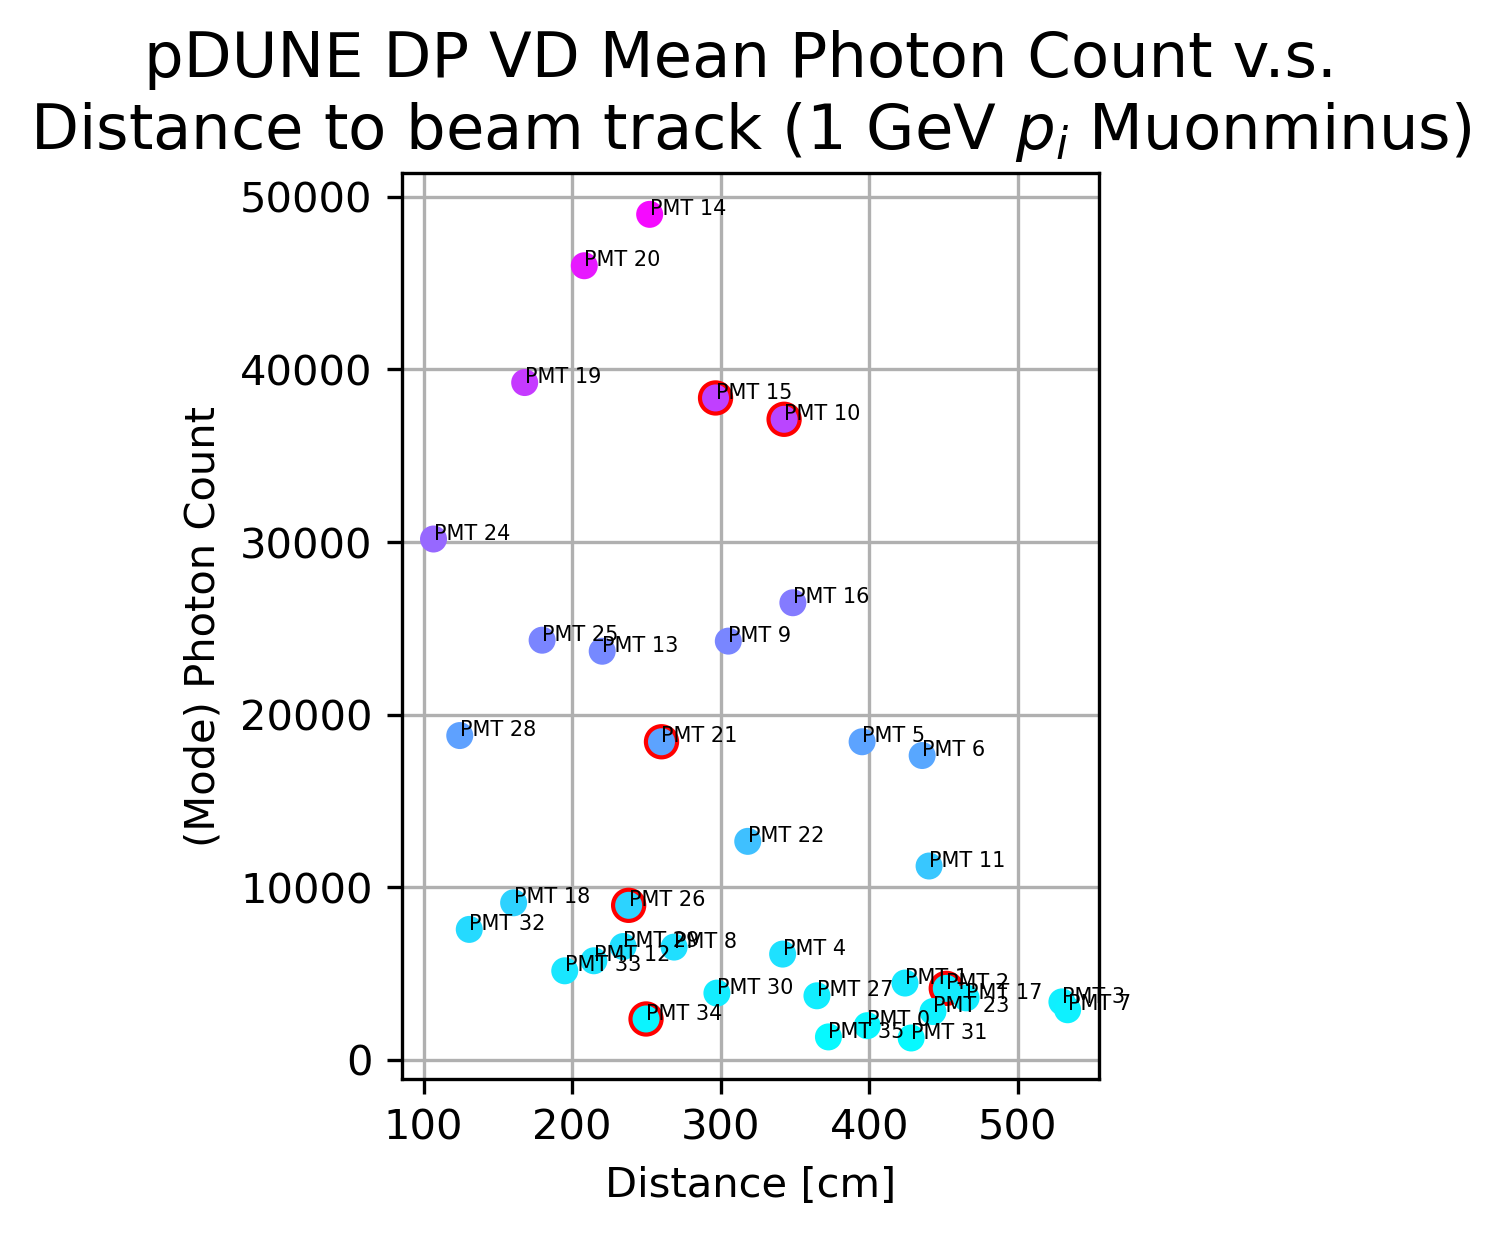

In [112]:
#Reset color axis limit---
color_axis_max = max( pmt_mean_phot_count) + 2000

plt.figure(dpi=300,figsize=(3,4))

# extract incident particle's initial position from file_suffix variable---
x0 = float(file_suffix[ file_suffix.rfind( '_', 0, file_suffix.find('X0')) + 1 : file_suffix.find('X0') ])
y0 = float(file_suffix[ file_suffix.rfind( '_', 0, file_suffix.find('Y0')) + 1 : file_suffix.find('Y0') ])
z0 = float(file_suffix[ file_suffix.rfind( '_', 0, file_suffix.find('Z0')) + 1 : file_suffix.find('Z0') ])

# calculate PMT distance to initial position of incident particle---
pmt_dist_to_init_pos = np.sqrt( np.power( pmt_xpos - x0, 2) + np.power( -410.3 - y0, 2) + np.power( pmt_zpos - z0, 2))


#My (Shuaixiang) suggestion:---
#pmt_dist_to_init_pos = np.sqrt(np.power(-376.5 - y0, 2) + np.power(pmt_zpos - z0, 2))

# start with the TPB-coated PMTs outline---
plt.scatter( pmt_dist_to_init_pos[coated_pmts], pmt_mean_phot_count[coated_pmts], 
            s=30,
            color="None", 
            edgecolors='red',
            linewidth=3)

# plot the color-coded and size-coded data
plt.scatter( pmt_dist_to_init_pos, pmt_mean_phot_count, 
#            s=pmt_mean_phot_count, 
            vmin=1, vmax=color_axis_max, s=30,#s is size---
            c=pmt_mean_phot_count,#c is color--- 
            cmap='cool')

plt.xlabel("Distance [cm]")
plt.ylabel("(Mode) Photon Count")
plt.title(f"pDUNE DP VD Mean Photon Count v.s. \nDistance to beam track ({eng_plot[:-1]} {eng_plot[-1:]}eV $p_i$ {part_plot})", fontsize=15)
plt.grid()



# label each of the PMTs with plain text---
for i, label in enumerate(pmt_labels):
     plt.annotate(label, 
                  (pmt_dist_to_init_pos[i], pmt_mean_phot_count[i]),
                  fontsize=5) # shift in position centers labels above points

#print the position of beam start point---
print("============================")
print('Beam start point: x = ', x0,', y = ', y0,', z = ', z0)
print("============================")        

### Plot PMT Positions with MEAN photon count data and TPB-coated PMTs labeled in orange.

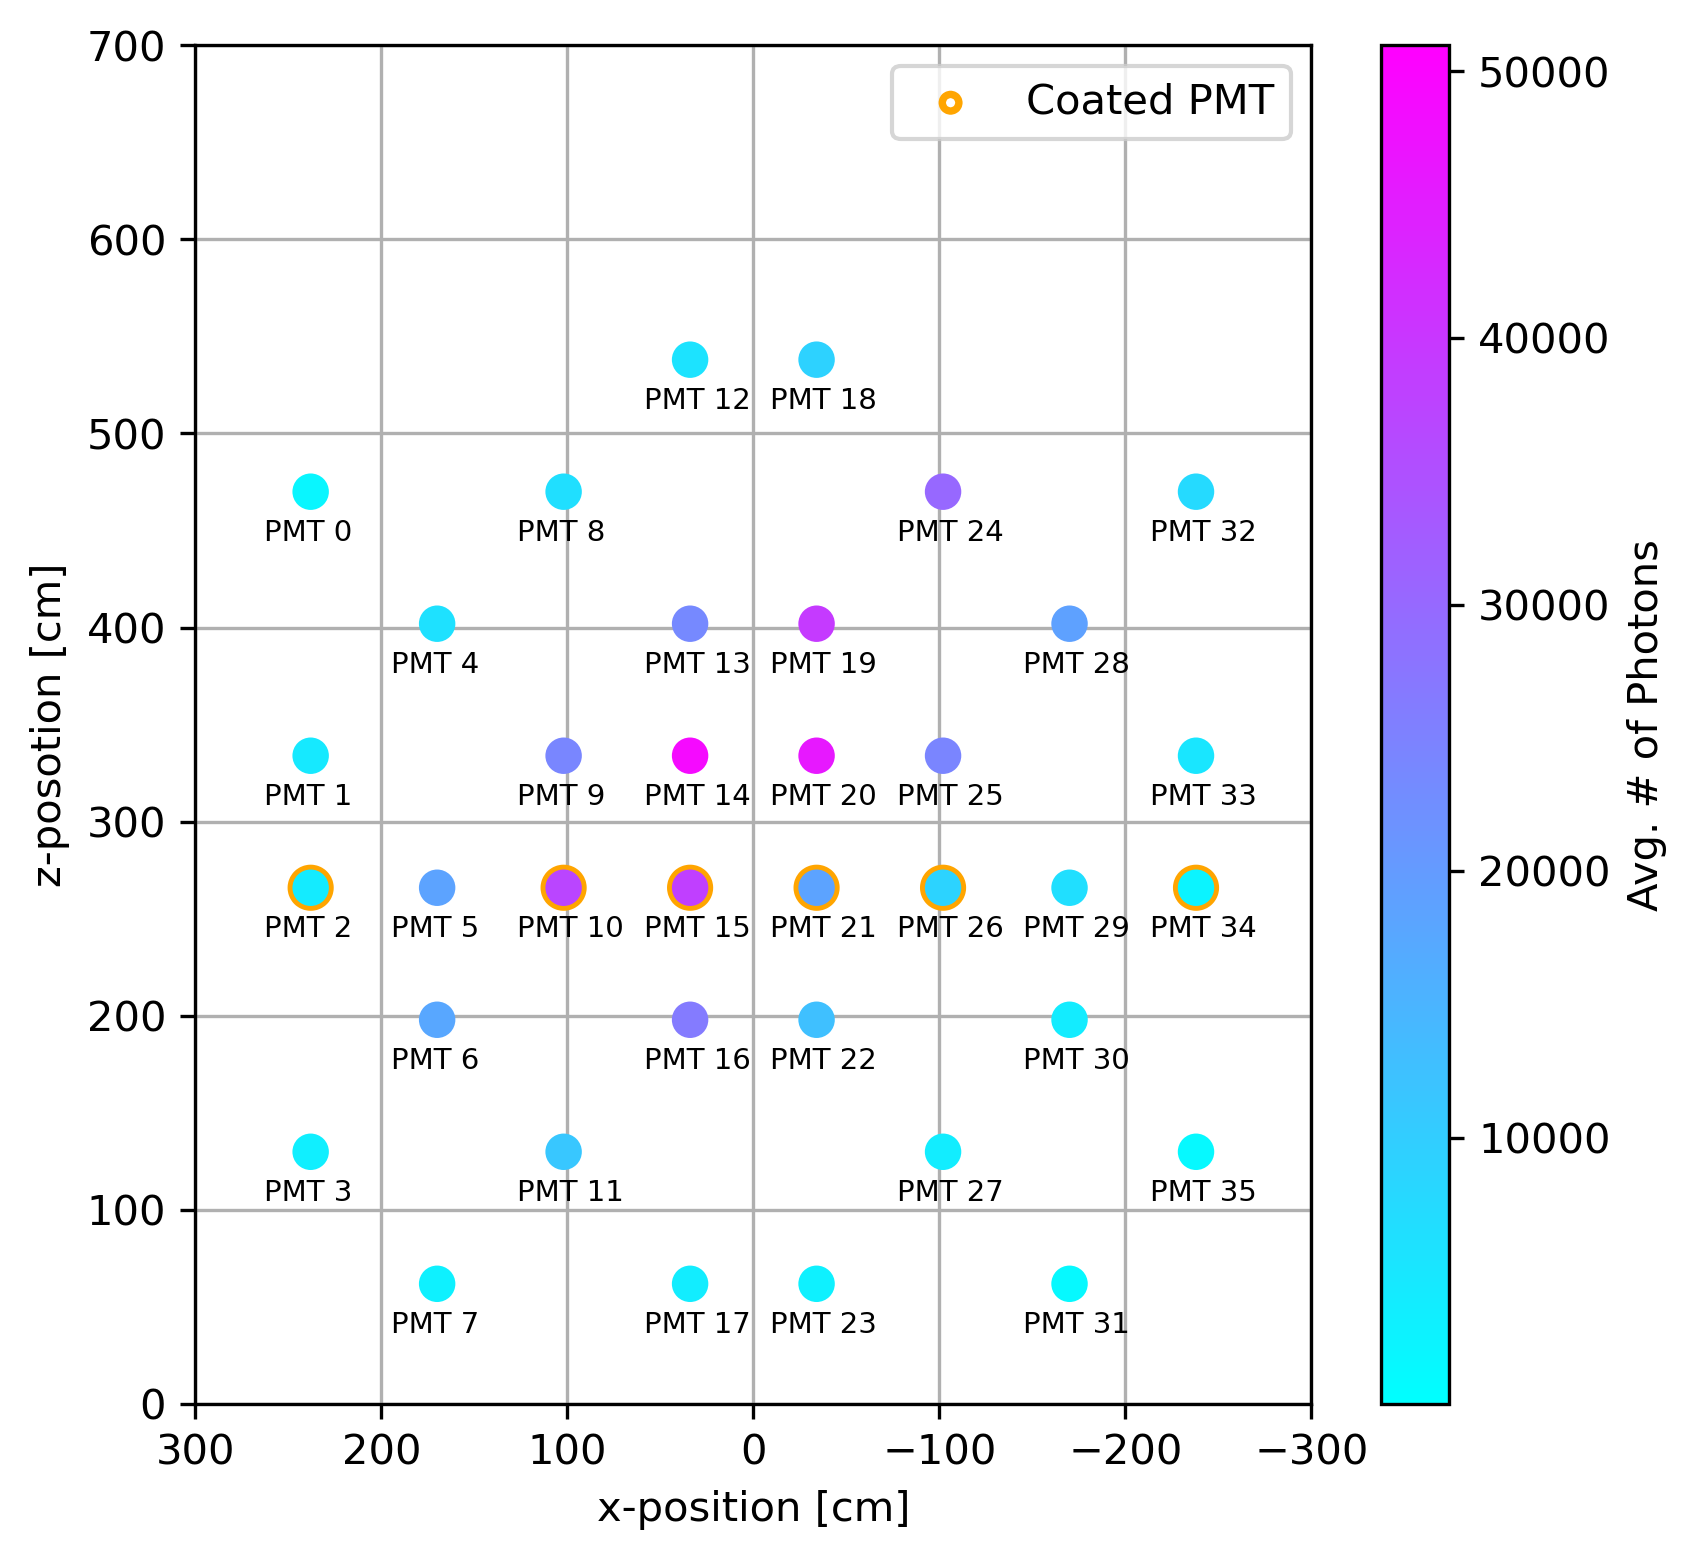

PMT 0 count is:  1975.42
PMT 1 count is:  4445.99
PMT 2 count is:  4137.26
PMT 3 count is:  3353.34
PMT 4 count is:  6123.28
PMT 5 count is:  18426.2
PMT 6 count is:  17629.0
PMT 7 count is:  2898.38
PMT 8 count is:  6528.94
PMT 9 count is:  24257.1
PMT 10 count is:  37110.6
PMT 11 count is:  11226.5
PMT 12 count is:  5736.59
PMT 13 count is:  23671.2
PMT 14 count is:  48984.5
PMT 15 count is:  38346.2
PMT 16 count is:  26481.1
PMT 17 count is:  3586.73
PMT 18 count is:  9097.29
PMT 19 count is:  39239.1
PMT 20 count is:  46006.9
PMT 21 count is:  18425.8
PMT 22 count is:  12655.0
PMT 23 count is:  2794.32
PMT 24 count is:  30173.1
PMT 25 count is:  24311.0
PMT 26 count is:  8949.21
PMT 27 count is:  3707.28
PMT 28 count is:  18785.3
PMT 29 count is:  6562.62
PMT 30 count is:  3863.43
PMT 31 count is:  1262.91
PMT 32 count is:  7554.15
PMT 33 count is:  5154.84
PMT 34 count is:  2363.77
PMT 35 count is:  1324.96


In [113]:
plt.figure(dpi=300,figsize=(6,6))

# start with the TPB-coated PMTs outline---
plt.scatter( pmt_xpos[coated_pmts], pmt_zpos[coated_pmts], 
            s=50,
            color="None", 
            edgecolors='orange',
            linewidth=4)

# create a legend just for the outline
plt.legend(['Coated PMT'], markerscale=0.25)

# plot the color-coded and size-coded data
plt.scatter( pmt_xpos, pmt_zpos, 
            vmin=1, vmax=color_axis_max, s=60,#s is size---
            c=pmt_mean_phot_count,#c is color--- 
            cmap='cool')

# make the plot look pretty
cbar = plt.colorbar() # add color axis to the right of the plot
cbar.set_label("Avg. # of Photons")
plt.xlabel("x-position [cm]")
plt.ylabel("z-posotion [cm]")
#plt.title(f"ProtoDUNE DP VD PMT Mean Photon Counts \n ({eng_plot[:-1]} {eng_plot[-1:]}eV $p_i$ {part_plot})", fontsize=15)
plt.xlim(-300, 300)
plt.ylim( 0, 700)
plt.gca().invert_xaxis()#To inverse x axis---
plt.grid()

# label each of the PMTs with plain text
for i, label in enumerate(pmt_labels):
     plt.annotate(label, 
                  (pmt_xpos[i]+25, pmt_zpos[i]-25),
                  fontsize=7) # shift in position centers labels above points

# save the figure
#plt.savefig("pDUNE_DP_VD_"+file_suffix+"PMT_mean_phot_counts_vmaxEq"+str(color_axis_max)+".jpeg")
plt.show()

#Output of photons counts in PMT:
for (pmt, count) in zip(pmt_labels, pmt_mean_phot_count):
    print(pmt, 'count is: ', count)


### Plot PMT positions with MODE photon count data and TPB-coated PMTs labeled in purple.

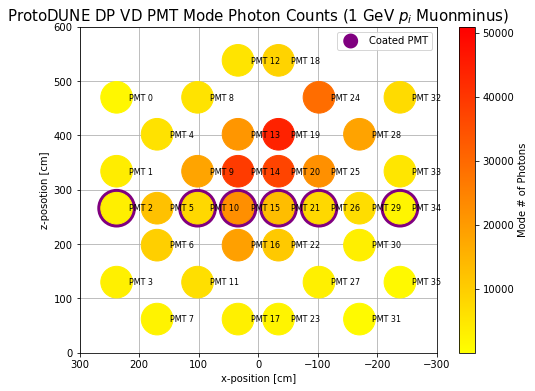

In [114]:
plt.figure( figsize=(8, 6))

# start with the TPB-coated PMTs outline
plt.scatter( pmt_xpos[coated_pmts], pmt_zpos[coated_pmts], 
#            s=pmt_mean_phot_count[coated_pmts], 
            s=1000,
            color="None", 
            edgecolors='purple',
            linewidth=7)

# create a legend just for the outline
plt.legend(['Coated PMT'], markerscale=0.25)

# plot the color-coded and size-coded data
plt.scatter( pmt_xpos, pmt_zpos, 
#            s=pmt_mean_phot_count, 
            vmin=1, vmax=color_axis_max, s=1000,
            c=pmt_mode, 
            cmap='autumn_r') # '_r' reverses the colormap

# make the plot look pretty
cbar = plt.colorbar() # add color axis to the right of the plot
cbar.set_label("Mode # of Photons")
plt.xlabel("x-position [cm]")
plt.ylabel("z-posotion [cm]")
plt.title(f"ProtoDUNE DP VD PMT Mode Photon Counts ({eng_plot[:-1]} {eng_plot[-1:]}eV $p_i$ {part_plot})", fontsize=15)
plt.xlim(-300, 300)
plt.ylim( 0, 600)
plt.gca().invert_xaxis()#To inverse x axis---
plt.grid()

# label each of the PMTs with plain text
for i, label in enumerate(pmt_labels):
     plt.annotate(label, 
                  (pmt_xpos[i]-21, pmt_zpos[i]-5),
                  fontsize=8) # shift in position centers labels above points

# save the figure
#plt.savefig("pDUNE_DP_VD_"+file_suffix+"PMT_mode_phot_counts_vmaxEq"+str(color_axis_max)+".jpeg")
plt.show()


## To get the ratio between PEN and Coating

For example of histogram and fitting, refer to:

https://blog.csdn.net/weixin_43156127/article/details/120665238


### Data:

**REF40_sim_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_1GeVP0_muons:**

PEN : [1887.25, 3335.71, 3785.53, 3951.44, 3786.15, 2564.85]

Coat: [1257.28, 2215.34, 2532.23, 2653.6, 2517.36, 1711.01]


**REF40_sim_0X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_1GeVP0_muons:**

PEN : [2963.59, 3223.68, 2824, 2208, 1601, 676]

Coat: [1987.01, 2146.76, 1893, 1495, 1058, 456]


**REF40_sim_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_0dot2GeVP0_muons:**

PEN : [63, 168, 260, 390, 510, 613]

Coat: [43, 113, 179, 263, 342, 412]


**REF40_sim_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_1GeVP0_muonNew:**

PEN : [1951, 3416, 3849, 4001, 3822, 2580]


Coat: [1302, 2266, 2574, 2683, 2539, 1721]


**REF40_sim_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_1GeVP0_muons:**


PEN : [1887, 3335, 3785, 3951, 3786, 2564]

Coat: [1257, 2215, 2532, 2653, 2517, 1711]


**REF40_sim_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_1GeVP0_proton:**

PEN : [188, 485, 734, 1044, 1329, 1420]

Coat: [132, 321, 498, 708, 891, 948]


**REF40_sim_-350X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_30GeVP0_muons:**

PEN : [5131, 6705, 7057, 7103, 6798, 5007]

Coat: [3428, 4457, 4733, 4778, 4525, 3344]


**REF60_sim_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_1GeVP0_muons:**

PEN : [2482, 4160, 4686, 4911, 4760, 3358]

Coat: [1625, 2723, 3067, 3228, 3098, 2196]

**REF90_sim_-238X0_-100Y0_300Z0_90Theta0XZ_0Theta0YZ_1GeVP0_muons:**

PEN : [4694, 6908, 7593, 7913, 7830, 6176]

Coat: [2979, 4378, 4806, 5042, 4931, 3887]





======The ratio is:======
[1.50105784 1.50573275 1.49493924 1.48908652 1.50401611 1.49902689
 1.49148218 1.501649   1.49181194 1.47692308 1.51323251 1.48245614
 1.46511628 1.48672566 1.45251397 1.48288973 1.49122807 1.48786408
 1.4984639  1.50750221 1.495338   1.49124115 1.50531705 1.49912841
 1.50119332 1.50564334 1.49486572 1.48925744 1.50417163 1.49853887
 1.42424242 1.51090343 1.47389558 1.47457627 1.49158249 1.4978903 ]

Mean =  1.4911528758087522
Sigma =  0.016949797430828615


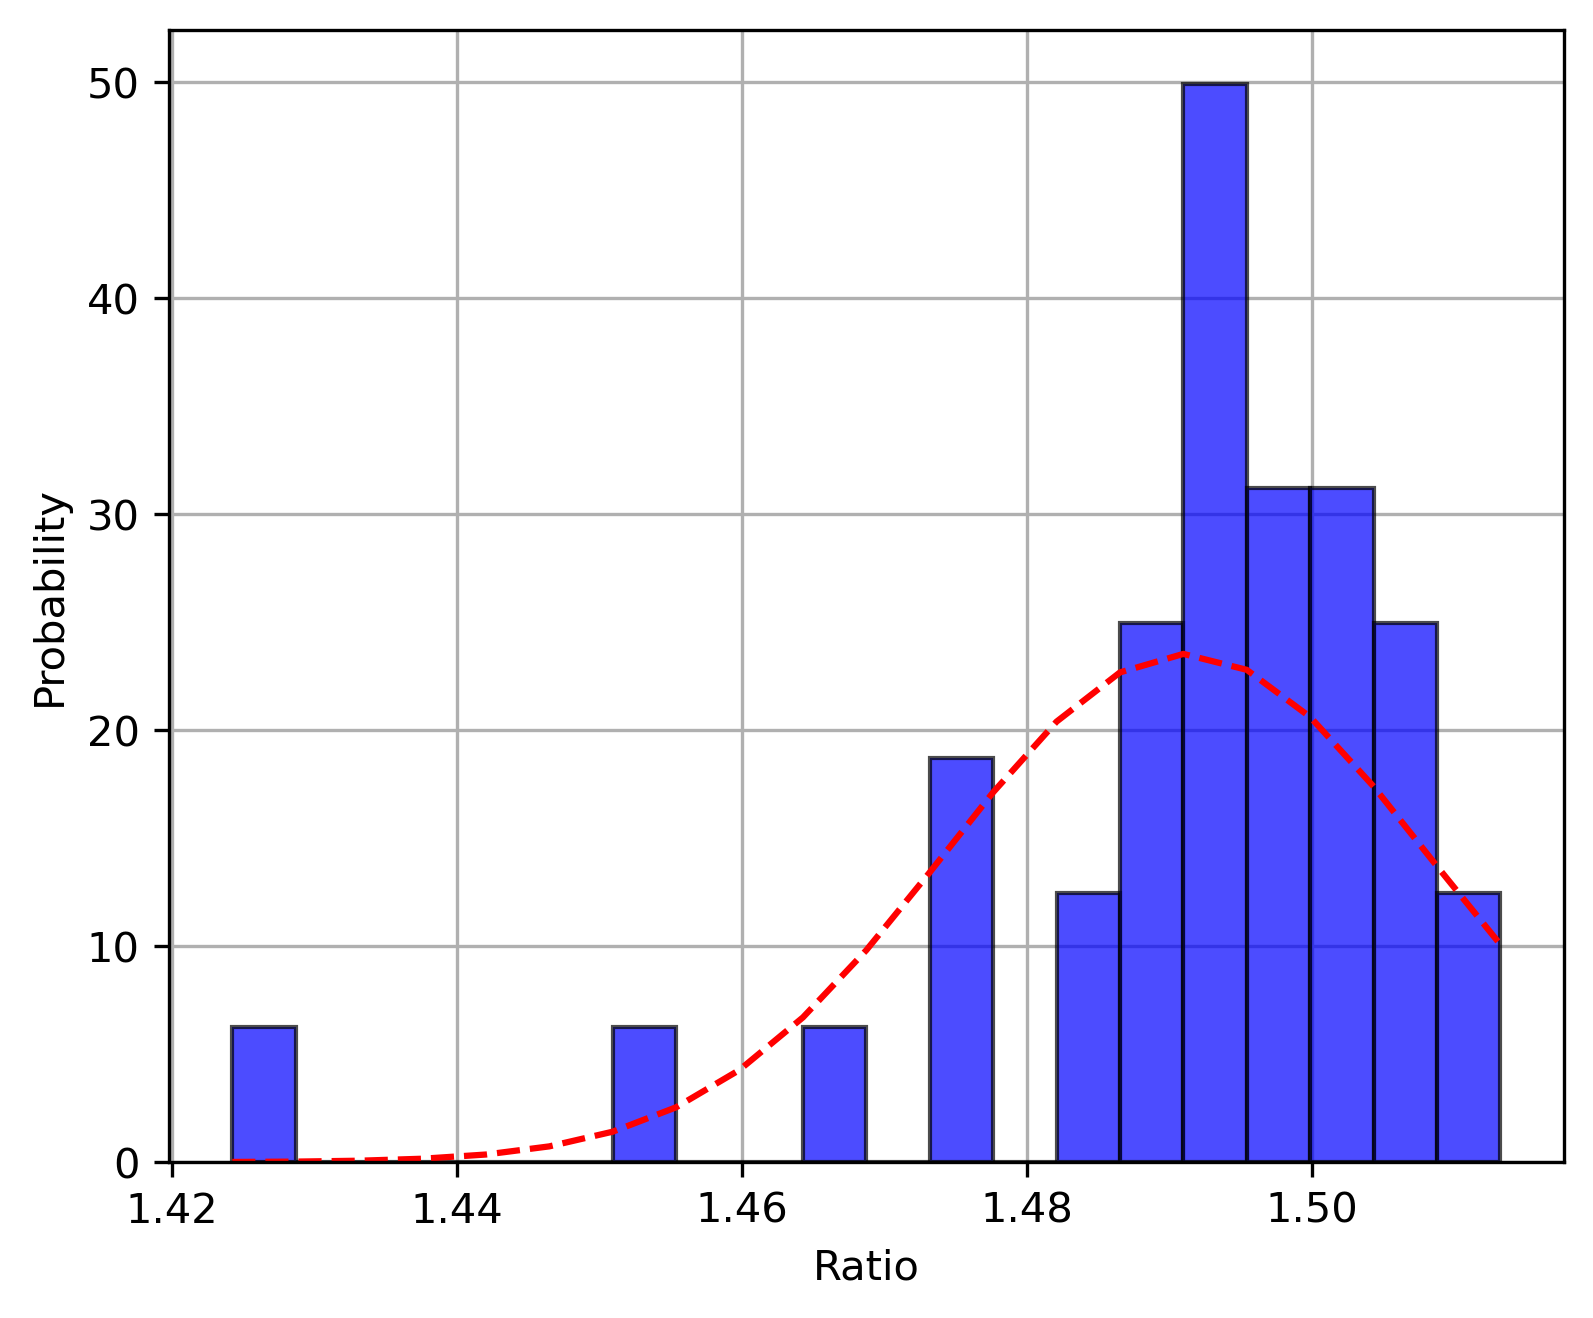

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

plt.figure(dpi=300,figsize=(6,5))


#PEN Photon Numbers:
counts_pen = np.array([1887.25, 3335.71, 3785.53, 3951.44, 3786.15, 2564.85,
                     2963.59, 3223.68, 2824, 2208, 1601, 676,
                     63, 168, 260, 390, 510, 613,
                     1951, 3416, 3849, 4001, 3822, 2580,
                     1887, 3335, 3785, 3951, 3786, 2564,
                     188, 485, 734, 1044, 1329, 1420])
#Coating Photon Numbers:
counts_coat = np.array([1257.28, 2215.34, 2532.23, 2653.6, 2517.36, 1711.01,
                     1987.01, 2146.76, 1893, 1495, 1058, 456,
                     43, 113, 179, 263, 342, 412,
                     1302, 2266, 2574, 2683, 2539, 1721,
                     1257, 2215, 2532, 2653, 2517, 1711,
                     132, 321, 498, 708, 891, 948])
#Ratio:
pmt_over_coat = counts_pen / counts_coat

#print:
print("======The ratio is:======")
print(pmt_over_coat)
print("=========================\n")

mu =np.mean(pmt_over_coat) #calculate mean value---
sigma =np.std(pmt_over_coat) #calculate sigma---

#mean, sigma = norm.fit(pmt_over_coat)

print("Mean = ", mu)
print("Sigma = ", sigma)

num_bins = 20 #number of bins---
n, bins, patches = plt.hist(pmt_over_coat, num_bins,density=True, edgecolor="black",
                            facecolor='blue', alpha=0.7)
y = norm.pdf(bins, mu, sigma)

plt.grid(True)
plt.plot(bins, y, 'r--') #draw the fitted curve---
plt.xlabel('Ratio') #draw x axis---
plt.ylabel('Probability') #draw y axis---

plt.show()




# Distribution after considering the efficiencies of PEN and Coat:

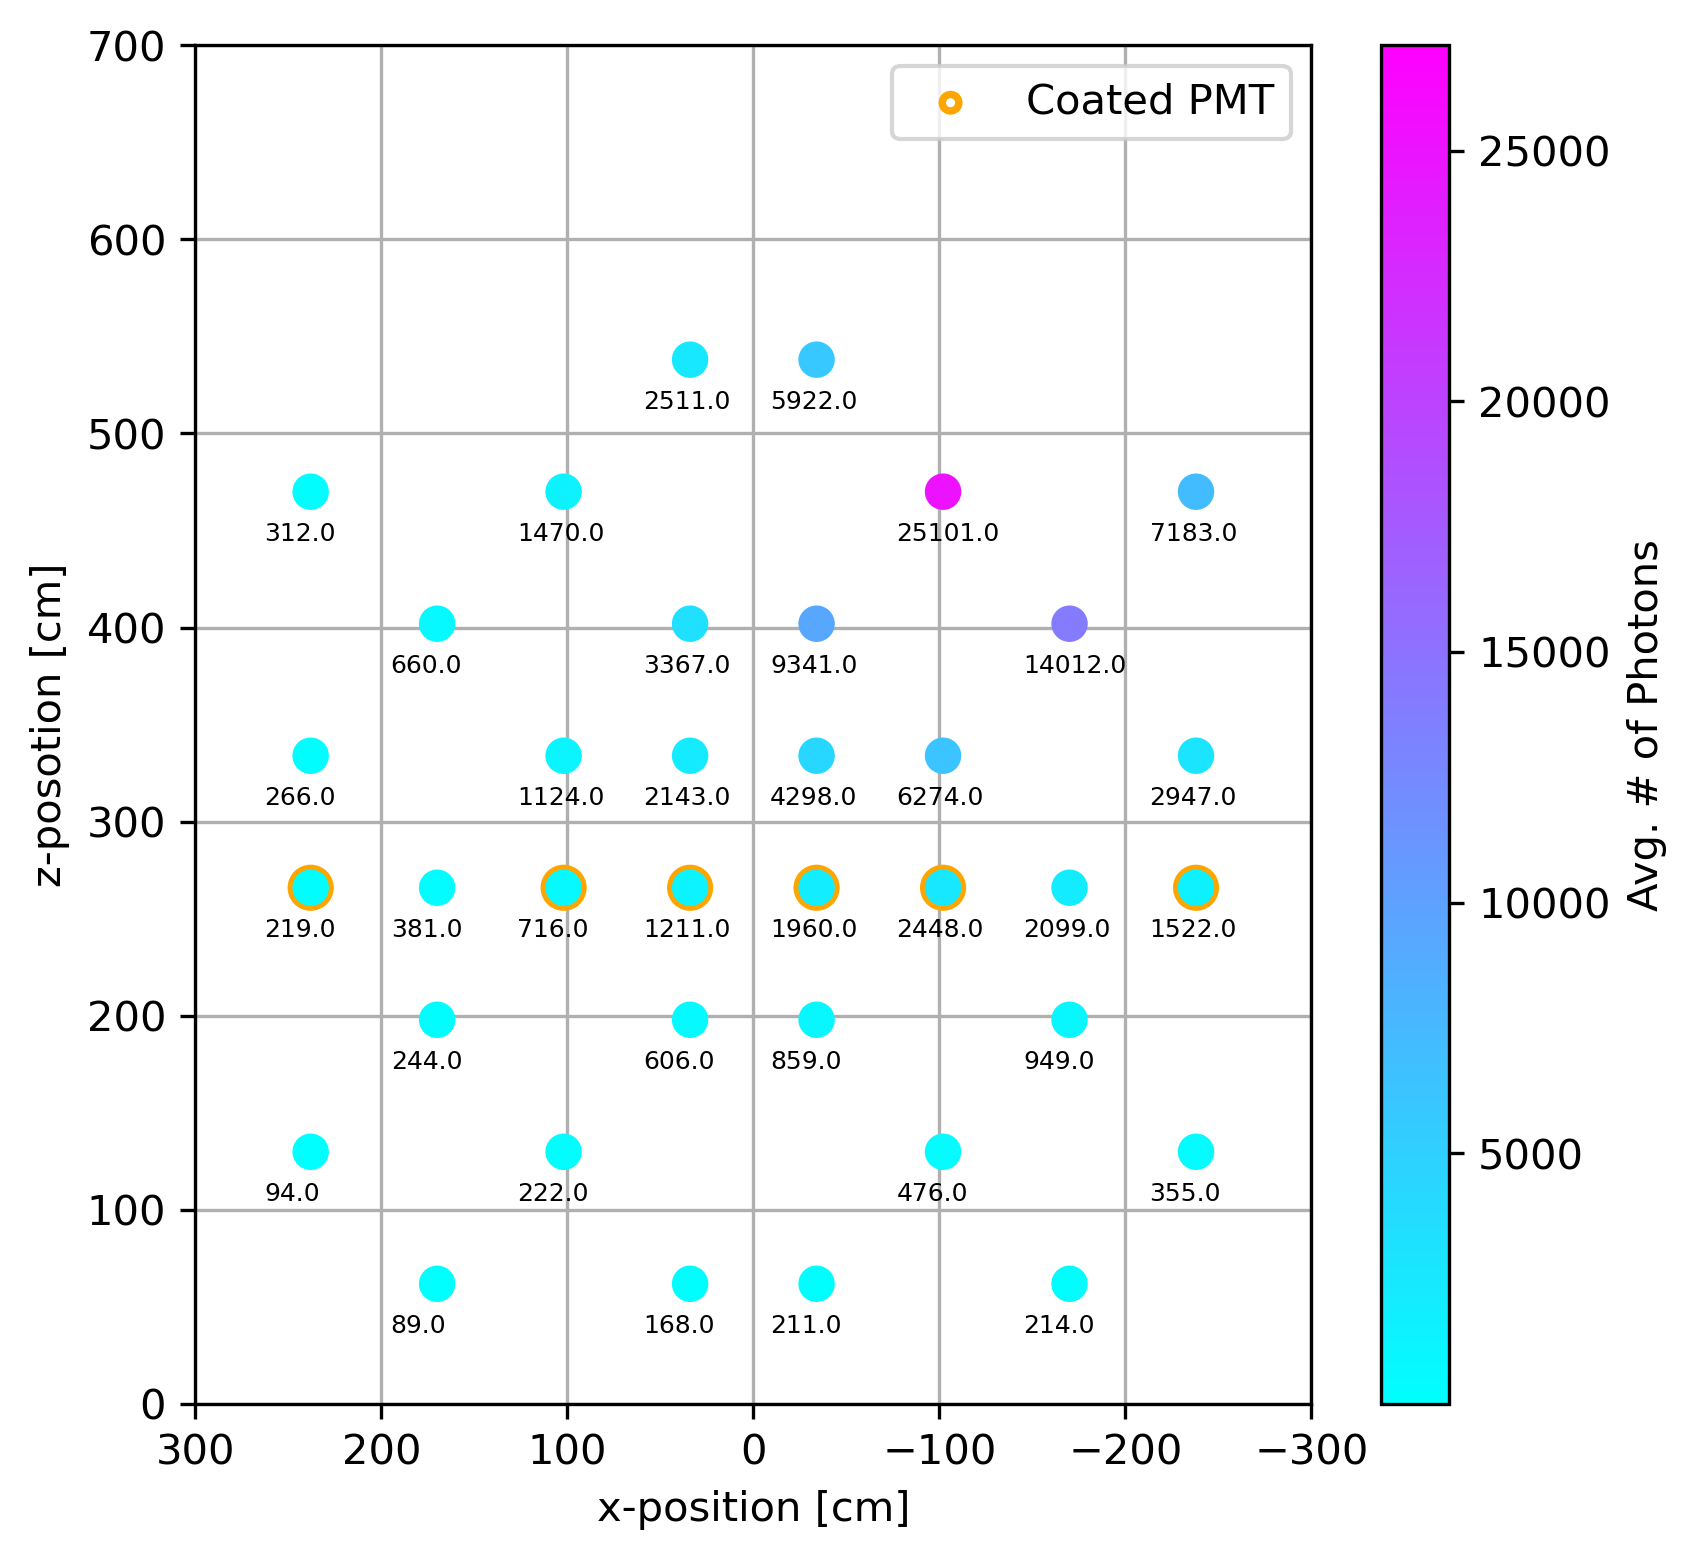

PMT 0 count is:  312.0
PMT 1 count is:  266.0
PMT 2 count is:  219.0
PMT 3 count is:  94.0
PMT 4 count is:  660.0
PMT 5 count is:  381.0
PMT 6 count is:  244.0
PMT 7 count is:  89.0
PMT 8 count is:  1470.0
PMT 9 count is:  1124.0
PMT 10 count is:  716.0
PMT 11 count is:  222.0
PMT 12 count is:  2511.0
PMT 13 count is:  3367.0
PMT 14 count is:  2143.0
PMT 15 count is:  1211.0
PMT 16 count is:  606.0
PMT 17 count is:  168.0
PMT 18 count is:  5922.0
PMT 19 count is:  9341.0
PMT 20 count is:  4298.0
PMT 21 count is:  1960.0
PMT 22 count is:  859.0
PMT 23 count is:  211.0
PMT 24 count is:  25101.0
PMT 25 count is:  6274.0
PMT 26 count is:  2448.0
PMT 27 count is:  476.0
PMT 28 count is:  14012.0
PMT 29 count is:  2099.0
PMT 30 count is:  949.0
PMT 31 count is:  214.0
PMT 32 count is:  7183.0
PMT 33 count is:  2947.0
PMT 34 count is:  1522.0
PMT 35 count is:  355.0


In [79]:
#Pay attention: each time pmt_mean_phot_count_Ratio will change.
#So please start from the start of this ipy file!!!

plt.figure(dpi=300,figsize=(6,6))

# start with the TPB-coated PMTs outline---
plt.scatter( pmt_xpos[coated_pmts], pmt_zpos[coated_pmts], 
            s=50,
            color="None", 
            edgecolors='orange',
            linewidth=4)

# create a legend just for the outline---
plt.legend(['Coated PMT'], markerscale=0.25)


#mu is defined in above block---
#initialize the counts after ratio---
pmt_mean_phot_count_Ratio = pmt_mean_phot_count
for coat in coated_pmts:
    pmt_mean_phot_count_Ratio[coat] = pmt_mean_phot_count[coat]*mu

#trunc---
pmt_mean_phot_count_int = np.floor(pmt_mean_phot_count_Ratio)
    
# plot the color-coded and size-coded data---
plt.scatter( pmt_xpos, pmt_zpos, 
            vmin=1, vmax=color_axis_max, s=60,#s is size---
            c=pmt_mean_phot_count_int,#c is color--- 
            cmap='cool')

# make the plot look pretty
cbar = plt.colorbar() # add color axis to the right of the plot
cbar.set_label("Avg. # of Photons")
plt.xlabel("x-position [cm]")
plt.ylabel("z-posotion [cm]")
#plt.title(f"ProtoDUNE DP VD PMT Mean Photon Counts \n ({eng_plot[:-1]} {eng_plot[-1:]}eV $p_i$ {part_plot})", fontsize=15)
plt.xlim(-300, 300)
plt.ylim( 0, 700)
plt.gca().invert_xaxis()#To inverse x axis---
plt.grid()

# label each of the PMTs with plain text
for i, label in enumerate(pmt_mean_phot_count_int):
     plt.annotate(label, 
                  (pmt_xpos[i]+25, pmt_zpos[i]-25),
                  fontsize=6) # shift in position centers labels above points

# save the figure
#plt.savefig("pDUNE_DP_VD_"+file_suffix+"PMT_mean_phot_counts_vmaxEq"+str(color_axis_max)+".jpeg")
plt.show()

#Output of photons counts in PMT:
for (pmt, count) in zip(pmt_labels, pmt_mean_phot_count_int):
    print(pmt, 'count is: ', count)

# Explore different energies on a certain PMT：

Useful plt.plot tutorial:

https://zhuanlan.zhihu.com/p/139052035

https://zhuanlan.zhihu.com/p/137828873

Text(0, 0.5, 'Counts')

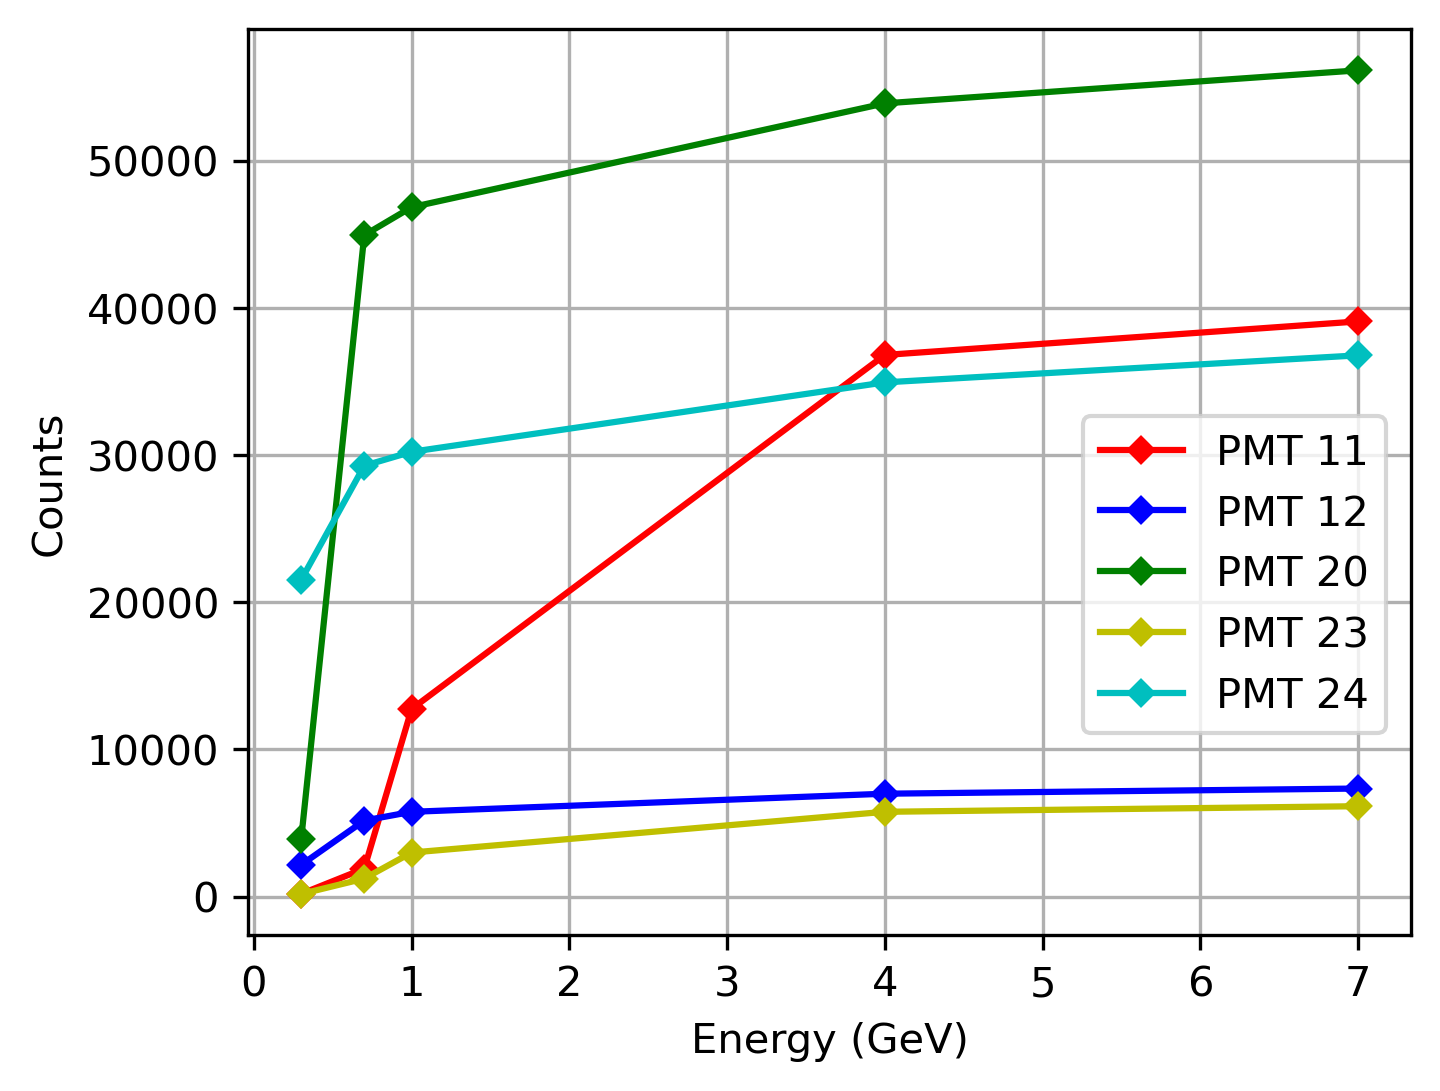

In [106]:
#Focus on PMT 20 this time---
energy = np.array([0.3, 0.7, 1.0, 4.0, 7.0])


pmt11 = np.array([183.37, 1902.05, 12742.2, 36796, 39074.8])
pmt12 = np.array([2151.59, 5165.81, 5758.19, 6988.65, 7339.86])
pmt20 = np.array([3889.2, 44936.3, 46836.7, 53890.8, 56133])
pmt23 = np.array([175.785, 1222.99, 2990.99, 5759.15, 6138.94])
pmt24 = np.array([21516.7, 29273.9, 30216.8, 34934.3, 36769.7])

plt.figure(dpi=300,figsize=(5,4))

plt.plot(energy, pmt11,"r-D", label='PMT 11', markersize=4)
plt.plot(energy, pmt12,"b-D", label='PMT 12', markersize=4)
plt.plot(energy, pmt20,"g-D", label='PMT 20', markersize=4)
plt.plot(energy, pmt23,"y-D", label='PMT 23', markersize=4)
plt.plot(energy, pmt24,"c-D", label='PMT 24', markersize=4)

plt.legend( ['PMT 11' ,'PMT 12', 'PMT 20', 'PMT 23', 'PMT 24'])
plt.legend(bbox_to_anchor=(0.7, 0.2))#control the location of legend---
plt.grid(True)
plt.xlabel('Energy (GeV)') #draw x axis---
plt.ylabel('Counts') #draw y axis---


### PMT Photon Count v. PMT Distance to Incident Particle Initial Position

Create a sorted list of PMTs that are closest to the starting position of the incident particle and include PMT photon count information in that list. Then plot the photon count as a function of PMT distance to the incident particle's starting position and fit that data with an exponential function.

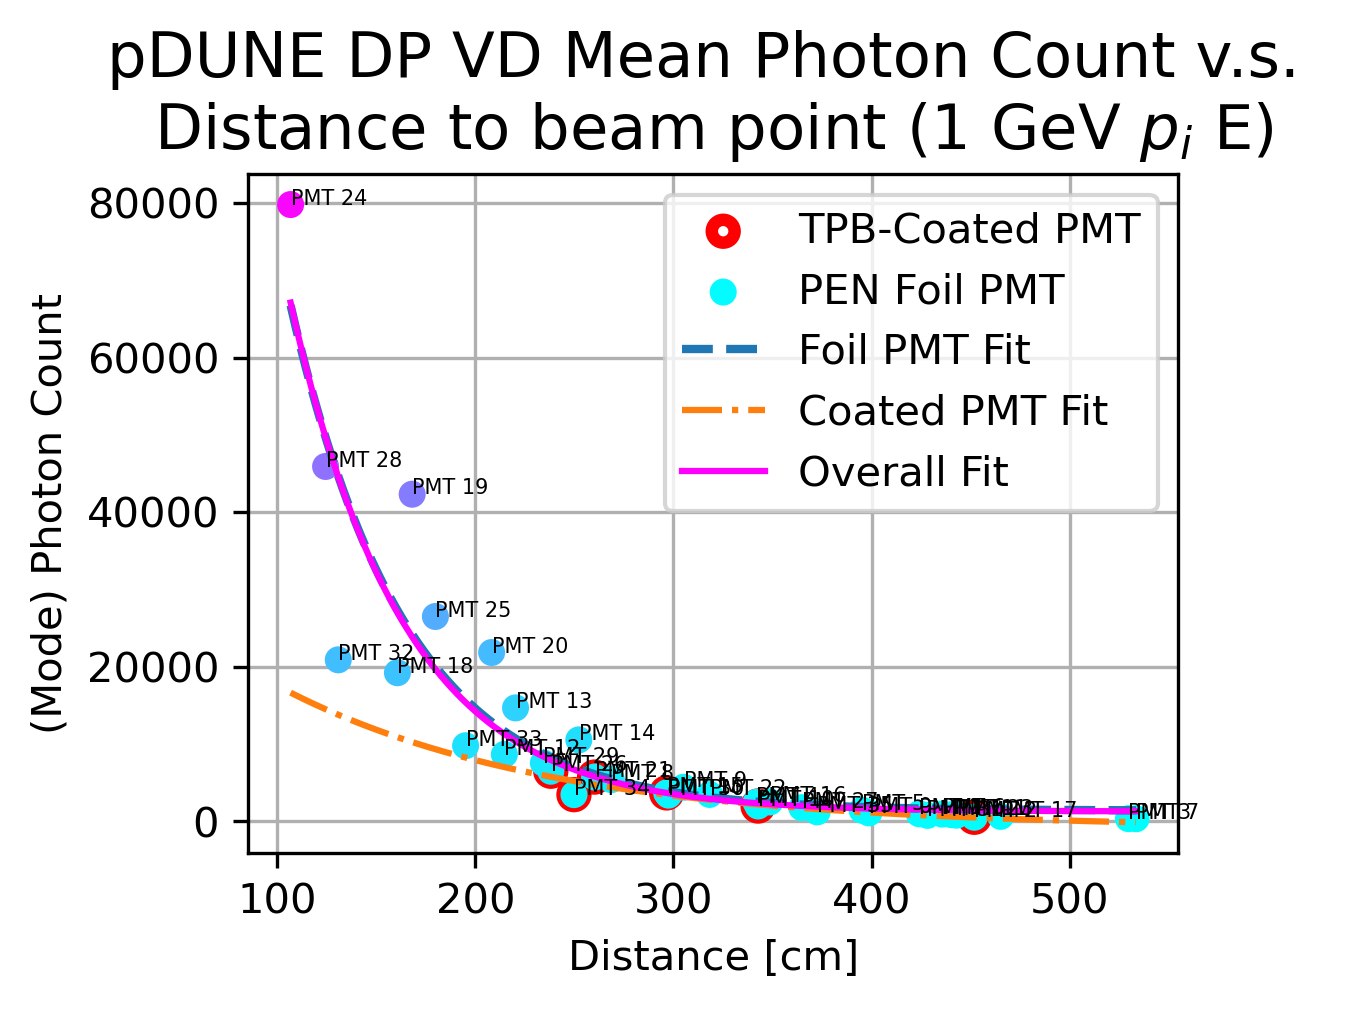

In [26]:
# fit functions for data---
def expo_fit_func(x, p0, r, b):
    return p0 * np.exp(r * x) + b

# fit the data (whole set, PEN foil PMTs, and TPB-coated PMTs) with curve_fit()
popt, pcov = curve_fit(expo_fit_func, pmt_dist_to_init_pos, pmt_mean_phot_count, 
                      p0=(5700, -1/100, 100),
                      maxfev=1000000)
popt_coated, pcov_coated = curve_fit(expo_fit_func, pmt_dist_to_init_pos[coated_pmts], pmt_mean_phot_count[coated_pmts],
                      p0=(5700, -1/100, 100),
                      maxfev=100000)
popt_foil, pcov_foil = curve_fit(expo_fit_func, pmt_dist_to_init_pos[foil_pmts], pmt_mean_phot_count[foil_pmts],
                      p0=(5700, -1/100, 100),
                      maxfev=100000)

# plot the data---
plt.figure(dpi=300,figsize=(4,3))
# start with the TPB-coated PMTs outline---
plt.scatter( pmt_dist_to_init_pos[coated_pmts], pmt_mean_phot_count[coated_pmts], 
            s=30,
            color="None", 
            edgecolors='red',
            linewidth=3)
# plot the color-coded and size-coded data
plt.scatter( pmt_dist_to_init_pos, pmt_mean_phot_count, 
#            s=pmt_mean_phot_count, 
            vmin=1, vmax=color_axis_max, s=30,#s is size---
            c=pmt_mean_phot_count,#c is color--- 
            cmap='cool')
#Set the labels--
plt.xlabel("Distance [cm]")
plt.ylabel("(Mode) Photon Count")
plt.title(f"pDUNE DP VD Mean Photon Count v.s. \nDistance to beam point ({eng_plot[:-1]} {eng_plot[-1:]}eV $p_i$ {part_plot})", fontsize=15)
plt.grid()

#Fitting---
plot_xrange = np.linspace( min(pmt_dist_to_init_pos), max(pmt_dist_to_init_pos), 10000)
plt.plot(plot_xrange, expo_fit_func(plot_xrange, *popt_foil), '--', linewidth=2)
plt.plot(plot_xrange, expo_fit_func(plot_xrange, *popt_coated), '-.')
plt.plot(plot_xrange, expo_fit_func(plot_xrange, *popt), color='magenta')
plt.legend( ['TPB-Coated PMT' ,'PEN Foil PMT', 'Foil PMT Fit', 'Coated PMT Fit', 'Overall Fit'])


# label each of the PMTs with plain text---
for i, label in enumerate(pmt_labels):
     plt.annotate(label, 
                  (pmt_dist_to_init_pos[i], pmt_mean_phot_count[i]),
                  fontsize=5) # shift in position centers labels above points



[398.66287763 424.11801424 451.90716967 529.76607102 341.71931464
 395.23675183 435.66511221 533.6029329  268.63374695 305.13618271
 342.71283898 440.3227112  214.59750698 220.22735979 252.18265206
 296.54694401 348.61452924 465.25271627 160.58670555 168.03597829
 208.16361354 260.14628577 318.22647596 442.94027814 106.64000188
 179.76676556 238.03380012 364.81788607 124.30643588 234.29061014
 297.46275397 428.26637739 130.70612074 195.00792292 249.74404898
 372.56420923]
[  340.12    357.335   535.365   649.74    779.32    803.85    873.745
   941.99    988.15   1102.38   1234.67   1449.45   1774.68   1988.28
  2459.89   2515.14   3393.36   3459.61   3485.91   3685.98   4419.23
  5402.43   5733.8    6488.14   7559.66   8663.57   9788.91  10544.6
 14681.1   19228.3   20896.3   21845.3   26502.4   42318.    45906.2
 79783.5  ]


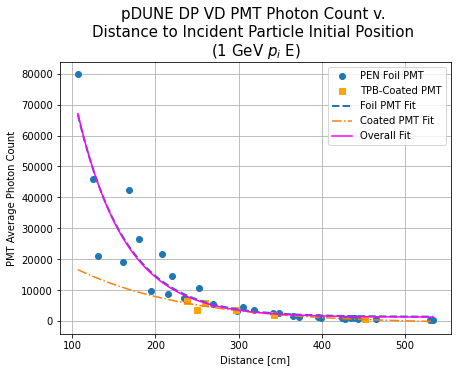

popt: [ 4.22043839e+05 -1.74227660e-02  1.26775604e+03]
popt_foil: [ 4.06676465e+05 -1.71436373e-02  1.39416803e+03]
popt_coated: [ 3.85305869e+04 -7.39543730e-03 -8.59355976e+02]


In [27]:
# fit functions for data
def expo_fit_func(x, p0, r, b):
    return p0 * np.exp(r * x) + b

# fit the data (whole set, PEN foil PMTs, and TPB-coated PMTs) with curve_fit()
popt, pcov = curve_fit(expo_fit_func, pmt_dist_to_init_pos, pmt_mean_phot_count, 
                      p0=(5700, -1/100, 100),
                      maxfev=1000000)
popt_coated, pcov_coated = curve_fit(expo_fit_func, pmt_dist_to_init_pos[coated_pmts], pmt_mean_phot_count[coated_pmts],
                      p0=(5700, -1/100, 100),
                      maxfev=100000)
popt_foil, pcov_foil = curve_fit(expo_fit_func, pmt_dist_to_init_pos[foil_pmts], pmt_mean_phot_count[foil_pmts],
                      p0=(5700, -1/100, 100),
                      maxfev=100000)

# plot the data
plt.figure( figsize=(7, 5))
print(pmt_dist_to_init_pos)
print(np.sort(pmt_mean_phot_count))
plt.scatter( pmt_dist_to_init_pos, pmt_mean_phot_count) 
plt.scatter( pmt_dist_to_init_pos[coated_pmts], pmt_mean_phot_count[coated_pmts],
           color='orange', marker='s') # give the TPB-coated pmts a different color and shape

plot_xrange = np.linspace( min(pmt_dist_to_init_pos), max(pmt_dist_to_init_pos), 10000)
plt.plot(plot_xrange, expo_fit_func(plot_xrange, *popt_foil), '--', linewidth=2)
plt.plot(plot_xrange, expo_fit_func(plot_xrange, *popt_coated), '-.')
plt.plot(plot_xrange, expo_fit_func(plot_xrange, *popt), color='magenta')

plt.legend(['PEN Foil PMT', 'TPB-Coated PMT', 'Foil PMT Fit', 'Coated PMT Fit', 'Overall Fit'])
        
plt.xlabel("Distance [cm]")
plt.ylabel("PMT Average Photon Count")
plt.title(f"pDUNE DP VD PMT Photon Count v. \nDistance to Incident Particle Initial Position \n({eng_plot[:-1]} {eng_plot[-1:]}eV $p_i$ {part_plot})", fontsize=15)
plt.grid() # give the plot a grid for viewing

#plt.savefig("pDUNE_DP_VD_"+file_suffix+"PMT_mean_phot_count_versus_dist_to_part_init_pos.jpeg")
plt.show()

print(f"popt: {popt}")
print(f"popt_foil: {popt_foil}")
print(f"popt_coated: {popt_coated}")

### Efficiency Calculations (Ratio of PEN Foil PMT Count to TPB-Coated PMT Count)

**The formulas are:**
    $$
    R=\frac{N_n}{N_d}\\\delta R=\frac1{N_d^2}\sqrt{N_d^2\left(\delta N_n\right)^2+N_n^2\left(\delta N_d\right)^2}
    $$

In [28]:
# gather the data
numerator_pmts   = np.array([33, 25, 20, 14, 9,  1])
denominator_pmts = np.array([34, 26, 21, 15, 10, 2])

num_mean_vals    = pmt_mean_phot_count[ numerator_pmts]
num_mode_vals    = pmt_mode[ numerator_pmts]
denom_mean_vals  = pmt_mean_phot_count[ denominator_pmts]
denom_mode_vals  = pmt_mode[ denominator_pmts]

err_mean_num     = np.sqrt( num_mean_vals)
err_mode_num     = np.sqrt( num_mode_vals)
err_mean_denom   = np.sqrt( denom_mean_vals)
err_mode_denom   = np.sqrt( denom_mode_vals)

In [29]:
# calculate ratios and print to the output data frame
mean_phot_count_ratio = num_mean_vals / denom_mean_vals
mode_phot_count_ratio = num_mode_vals / denom_mode_vals

# error propagation is done for the ratio in the standard fashion
# of sqrt(  (df/dx1)^2 \sigma_x1^2 + ...  ) for all variables xi. 

mean_phot_count_ratio_err =np.sqrt((denom_mean_vals)**2*(err_mean_num)**2 
                                   + (num_mean_vals)**2*(err_mean_denom)**2)/((denom_mean_vals)**2)
mode_phot_count_ratio_err =np.sqrt((denom_mode_vals)**2*(err_mode_num)**2 
                                   + (num_mode_vals)**2*(err_mode_denom)**2)/((denom_mode_vals)**2)

# save the efficiency ratio data to a csv file
pmts_in_ratio = np.array([f'{n}/{d}' for n, d in zip( numerator_pmts, denominator_pmts)])

# we have columnar data, but we need to organize it in rows
data_out = np.array( 
    [ [pmt, mean, mean_err, mode, mode_err] for 
     pmt, mean, mean_err, mode, mode_err 
     in zip( pmts_in_ratio, 
            mean_phot_count_ratio, 
            mean_phot_count_ratio_err, 
            mode_phot_count_ratio, 
            mode_phot_count_ratio_err) ])

df_out = pd.DataFrame(data_out, columns = ['pmtX_over_pmtY', 'Ratio(mean)', 'Ratio_err(mean)', 'Ratio(mode)', 'Ratio_err(mode)'])
#df_out.to_csv('PEN_over_TBP_PMT_efficiencies'+file_suffix+'.csv')

print( df_out)

  pmtX_over_pmtY         Ratio(mean)       Ratio_err(mean)  \
0          33/34   2.829483670124667  0.055964178740999376   
1          25/26   4.084745396985885   0.05657922517703941   
2          20/21  3.8099166346925246  0.056533417651699745   
3          14/15   2.860731745695853  0.054739004360687016   
4           9/10  2.2226396684571585  0.060020779709617084   
5            1/2   1.845750095729082   0.09905122288353811   

          Ratio(mode)      Ratio_err(mode)  
0   2.982806629834254  0.05916532263144084  
1  3.8516852508869737  0.05581762712378963  
2   3.998566681568262   0.0678658146968948  
3  3.6067782505910166  0.07927717805038292  
4  1.8988268370607029  0.05304465630515206  
5  1.8971200000000001  0.10419529900440463  
